In [8]:
#!pip install tensorflow tcn

ERROR: Could not find a version that satisfies the requirement tcn (from versions: none)
ERROR: No matching distribution found for tcn



Training MLP...

MLP Model Performance:
Accuracy: 0.8700204290091931
F1-Score: 0.8682098268523493
ROC-AUC: 0.9400909915164315


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


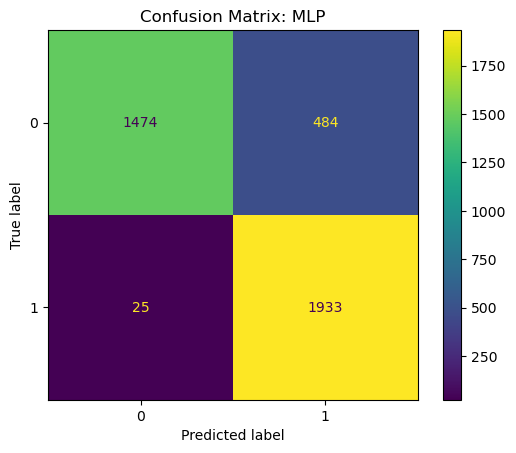

AttributeError: 'MLPClassifier' object has no attribute 'loss_curve_'

In [100]:
import pandas as pd
import pickle
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Load the dataset
dataset = pd.read_csv("sepsis_data.csv")
dataset = dataset.sample(n=10000, random_state=123)

# Resample the data to handle class imbalance
df_majority = dataset[dataset.SepsisLabel == 0]
df_minority = dataset[dataset.SepsisLabel == 1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,  
                                 n_samples=len(df_majority),    
                                 random_state=123)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Separate features and labels
X = df_upsampled.iloc[:, :-1].values
Y = df_upsampled['SepsisLabel'].values

# Stratified Sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=0)
for train_index, test_index in sss.split(X, Y):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

# Define models
models = {
    "MLP": MLPClassifier(
        activation='tanh',
        hidden_layer_sizes=(10, 5),
        max_iter=20000,
        solver='lbfgs',
        random_state=1,
        verbose=True
    ),
    "DecisionTree": DecisionTreeClassifier(random_state=0),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=0)
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = classification_report(Y_test, Y_pred, output_dict=True)['weighted avg']['f1-score']
    roc_auc = roc_auc_score(Y_test, model.predict_proba(X_test)[:, 1]) if hasattr(model, "predict_proba") else None

    results[name] = {
        "Accuracy": accuracy,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    }

    print("\nMLP Model Performance:")
    print(f"Accuracy: {accuracy}")
    print(f"F1-Score: {f1}")
    print(f"ROC-AUC: {roc_auc}")
    
    # Confusion Matrix
    cm = confusion_matrix(Y_test, Y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(f"Confusion Matrix: {name}")
    plt.show()
    
    # Loss curve for MLP
    if name == "MLP":
        plt.plot(model.loss_curve_)
        plt.title("Loss Curve")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()

    # Save model
    #with open(f"{name.lower()}_model.sav", "wb") as file:
        #pickle.dump(model, file)

    filename = 'mlp_model.sav'
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Cross-validation
for name, model in models.items():
    if name != "MLP":  # MLP verbose outputs during training
        scores = cross_val_score(model, X, Y, cv=5, scoring="accuracy")
        print(f"{name} Cross-Validation Accuracy: {np.mean(scores)}")



Logistic Regression Model Performance:
Accuracy: 0.7818332907184863
F1-Score: 0.7818265431888075
ROC-AUC: 0.8576804724605991


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


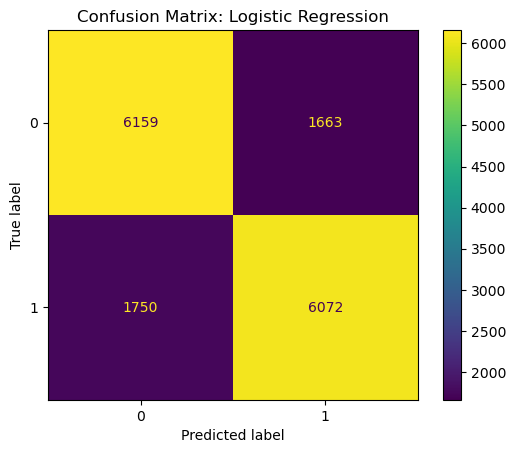

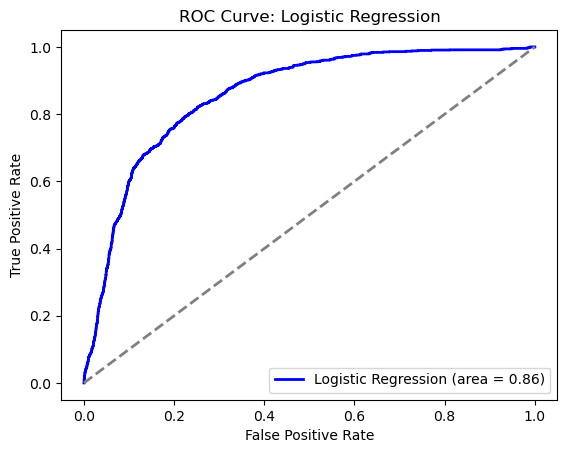

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

# Define and train the Logistic Regression model
logistic_model = LogisticRegression(max_iter=10000, random_state=0)
logistic_model.fit(X_train, Y_train)

# Make predictions
Y_pred_logistic = logistic_model.predict(X_test)
Y_proba_logistic = logistic_model.predict_proba(X_test)[:, 1]

# Evaluate the Logistic Regression model
accuracy_logistic = accuracy_score(Y_test, Y_pred_logistic)
roc_auc_logistic = roc_auc_score(Y_test, Y_proba_logistic)
f1_logistic = classification_report(Y_test, Y_pred_logistic, output_dict=True)['weighted avg']['f1-score']

print("\nLogistic Regression Model Performance:")
print(f"Accuracy: {accuracy_logistic}")
print(f"F1-Score: {f1_logistic}")
print(f"ROC-AUC: {roc_auc_logistic}")

# Confusion Matrix
cm_logistic = confusion_matrix(Y_test, Y_pred_logistic)
disp_logistic = ConfusionMatrixDisplay(confusion_matrix=cm_logistic, display_labels=logistic_model.classes_)
disp_logistic.plot()
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(Y_test, Y_proba_logistic)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"Logistic Regression (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Logistic Regression")
plt.legend(loc="lower right")
plt.show()

# Save the Logistic Regression model
filename = 'logistic_regression_model.sav'
with open(filename, 'wb') as file:
    pickle.dump(logistic_model, file)



Decision Tree Model Performance:
Accuracy: 0.9459217591408847
F1-Score: 0.9458695172576491
ROC-AUC: 0.9732286552081434


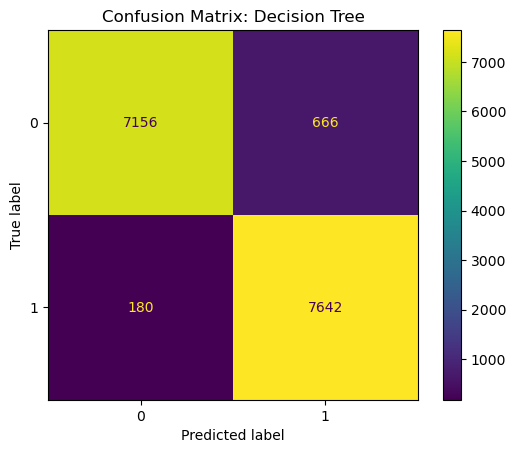

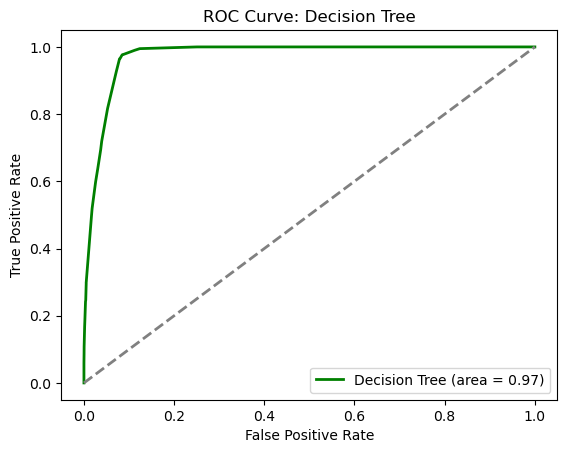

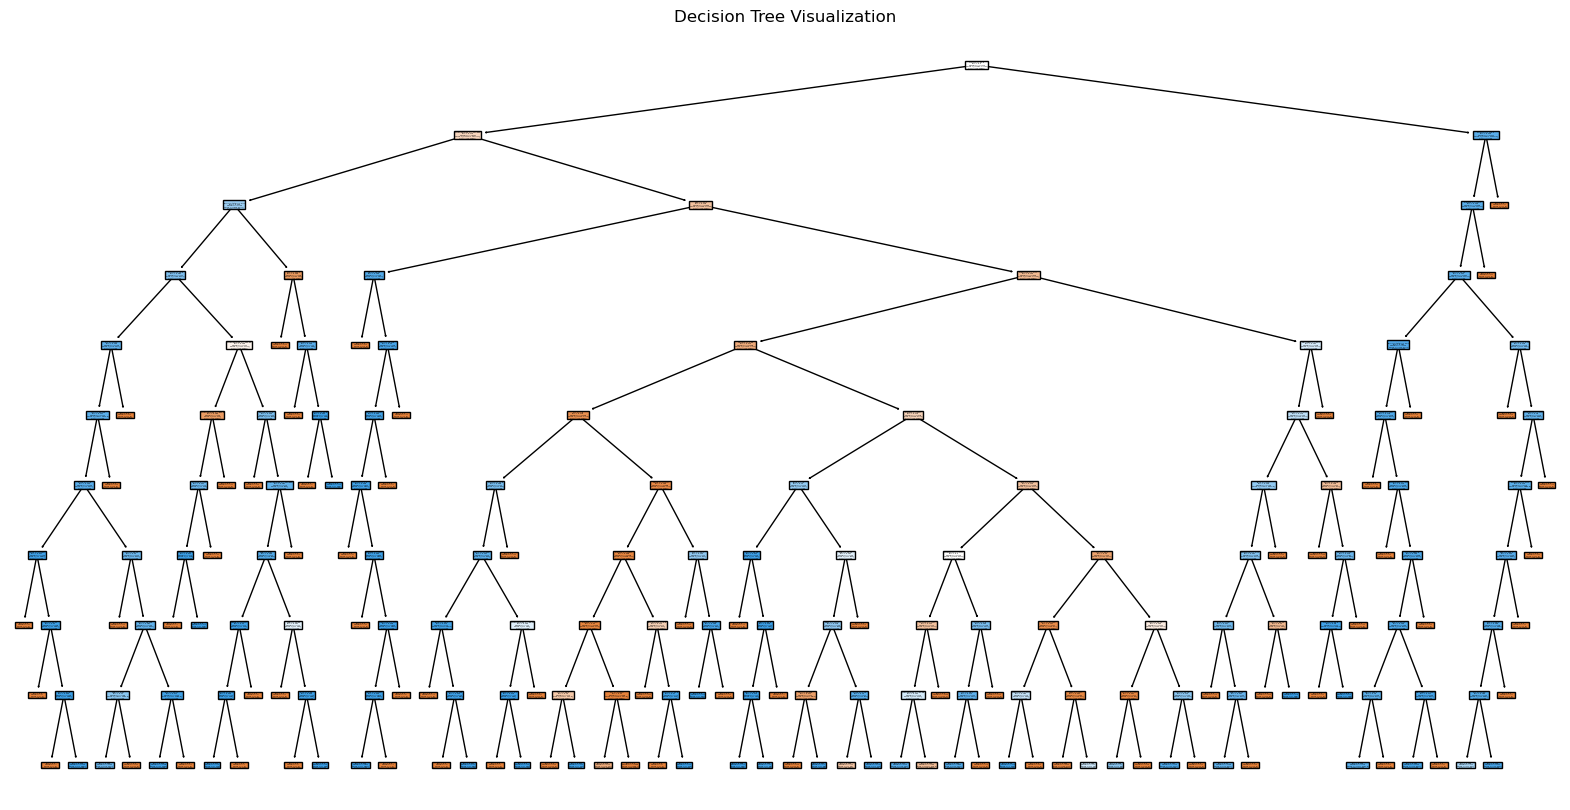

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn import tree

# Define and train the Decision Tree model
tree_model = DecisionTreeClassifier(random_state=0, max_depth=10)  # Limiting depth for interpretability and to prevent overfitting
tree_model.fit(X_train, Y_train)

# Make predictions
Y_pred_tree = tree_model.predict(X_test)
Y_proba_tree = tree_model.predict_proba(X_test)[:, 1]

# Evaluate the Decision Tree model
accuracy_tree = accuracy_score(Y_test, Y_pred_tree)
roc_auc_tree = roc_auc_score(Y_test, Y_proba_tree)
f1_tree = classification_report(Y_test, Y_pred_tree, output_dict=True)['weighted avg']['f1-score']

print("\nDecision Tree Model Performance:")
print(f"Accuracy: {accuracy_tree}")
print(f"F1-Score: {f1_tree}")
print(f"ROC-AUC: {roc_auc_tree}")

# Confusion Matrix
cm_tree = confusion_matrix(Y_test, Y_pred_tree)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=tree_model.classes_)
disp_tree.plot()
plt.title("Confusion Matrix: Decision Tree")
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(Y_test, Y_proba_tree)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='green', lw=2, label=f"Decision Tree (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Decision Tree")
plt.legend(loc="lower right")
plt.show()

# Visualize the tree (optional)
plt.figure(figsize=(20, 10))
tree.plot_tree(tree_model, feature_names=dataset.columns[:-1], class_names=["No Sepsis", "Sepsis"], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

# Save the Decision Tree model
filename = 'decision_tree_model.sav'
with open(filename, 'wb') as file:
    pickle.dump(tree_model, file)



XGBoost Model Performance on Test Set:
Accuracy: 0.9990800770983004
F1-Score: 0.9990800763198074
ROC-AUC: 0.999970290774145
False Negatives: 0


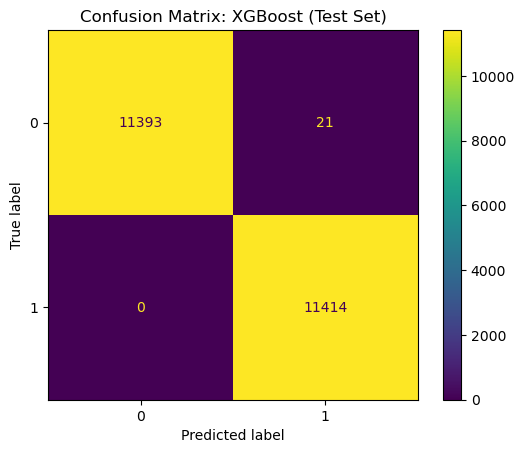

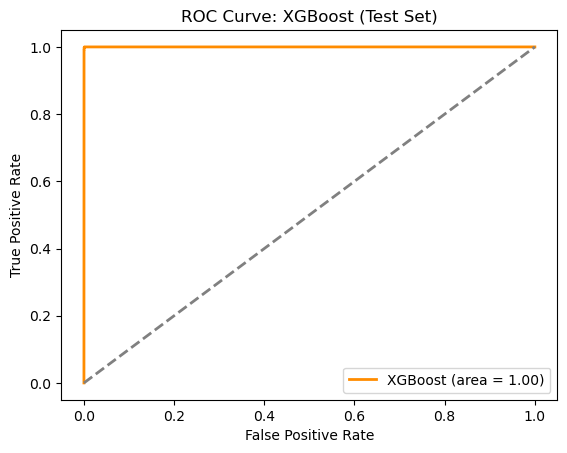

In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# Load the dataset
dataset = pd.read_csv("sepsis_data.csv")  # Replace with your dataset path

# Separate the majority and minority classes
df_majority = dataset[dataset.SepsisLabel == 0]
df_minority = dataset[dataset.SepsisLabel == 1]

# Upsample the minority class
df_minority_upsampled = resample(
    df_minority,
    replace=True,  # Allow resampling with replacement
    n_samples=len(df_majority),  # Match the majority class size
    random_state=123
)

# Combine the majority class and upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=123).reset_index(drop=True)

# Separate features and labels
X = df_balanced.iloc[:, :-1].values
Y = df_balanced['SepsisLabel'].values

# Split into training and testing sets (80/20 split)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

# Define and train the XGBoost model
xgb_model = XGBClassifier(
    random_state=0,
    scale_pos_weight=1.0,  # Data is now balanced, so no weight adjustment is needed
    max_depth=5,  # Limit tree depth to prevent overfitting
    learning_rate=0.1,  # Step size for optimization
    n_estimators=10000  # Number of boosting rounds
)
xgb_model.fit(X_train, Y_train)  # Train on the training set

# Make predictions on the test set
Y_pred_xgb = xgb_model.predict(X_test)
Y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the XGBoost model on the test set
accuracy_xgb = accuracy_score(Y_test, Y_pred_xgb)
roc_auc_xgb = roc_auc_score(Y_test, Y_proba_xgb)
f1_xgb = classification_report(Y_test, Y_pred_xgb, output_dict=True)['weighted avg']['f1-score']
false_negatives_xgb = ((Y_test == 1) & (Y_pred_xgb == 0)).sum()  # Count false negatives

print("\nXGBoost Model Performance on Test Set:")
print(f"Accuracy: {accuracy_xgb}")
print(f"F1-Score: {f1_xgb}")
print(f"ROC-AUC: {roc_auc_xgb}")
print(f"False Negatives: {false_negatives_xgb}")

# Confusion Matrix
cm_xgb = confusion_matrix(Y_test, Y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb_model.classes_)
disp_xgb.plot()
plt.title("Confusion Matrix: XGBoost (Test Set)")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(Y_test, Y_proba_xgb)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"XGBoost (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: XGBoost (Test Set)")
plt.legend(loc="lower right")
plt.show()

# Save the XGBoost model
filename = 'xgboost_model_with_split.sav'
with open(filename, 'wb') as file:
    pickle.dump(xgb_model, file)



Stacking Model Performance:
Accuracy: 0.997379186908719
F1-Score: 0.9973791689071181
ROC-AUC: 0.999336391708613
False Negatives: 0


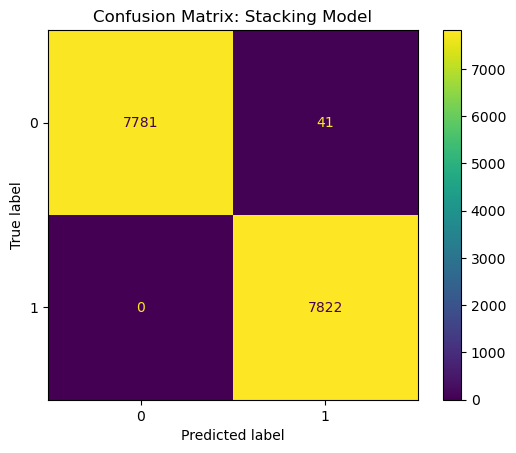

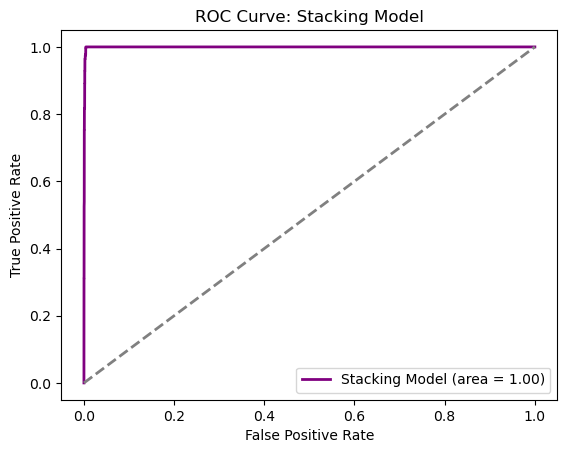

In [40]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define base models
base_models = [
    ('xgb', XGBClassifier(random_state=0, scale_pos_weight=len(df_majority) / len(df_minority))),
    ('mlp', MLPClassifier(hidden_layer_sizes=(10, 5), max_iter=40000, solver='lbfgs', random_state=1)),
    ('tree', DecisionTreeClassifier(max_depth=10, random_state=0))
]

# Meta-model
meta_model = LogisticRegression()

# Stacking Classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
stacking_model.fit(X_train, Y_train)

# Make predictions
Y_pred_stack = stacking_model.predict(X_test)
Y_proba_stack = stacking_model.predict_proba(X_test)[:, 1]

# Evaluate the Stacking Model
accuracy_stack = accuracy_score(Y_test, Y_pred_stack)
roc_auc_stack = roc_auc_score(Y_test, Y_proba_stack)
f1_stack = classification_report(Y_test, Y_pred_stack, output_dict=True)['weighted avg']['f1-score']
false_negatives_stack = ((Y_test == 1) & (Y_pred_stack == 0)).sum()  # Count false negatives

# Print Metrics
print("\nStacking Model Performance:")
print(f"Accuracy: {accuracy_stack}")
print(f"F1-Score: {f1_stack}")
print(f"ROC-AUC: {roc_auc_stack}")
print(f"False Negatives: {false_negatives_stack}")

# Confusion Matrix
cm_stack = confusion_matrix(Y_test, Y_pred_stack)
disp_stack = ConfusionMatrixDisplay(confusion_matrix=cm_stack, display_labels=[0, 1])
disp_stack.plot()
plt.title("Confusion Matrix: Stacking Model")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(Y_test, Y_proba_stack)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='purple', lw=2, label=f"Stacking Model (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Stacking Model")
plt.legend(loc="lower right")
plt.show()

# Save the Stacking Model
filename = 'stacking_model.sav'
with open(filename, 'wb') as file:
    pickle.dump(stacking_model, file)


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 1/200: Training Loss = 0.7016, Validation Loss = 0.6976
Epoch 2/200: Training Loss = 0.6799, Validation Loss = 0.6783


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 3/200: Training Loss = 0.6752, Validation Loss = 0.6729
Epoch 4/200: Training Loss = 0.6738, Validation Loss = 0.6718


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 5/200: Training Loss = 0.6734, Validation Loss = 0.6716
Epoch 6/200: Training Loss = 0.6730, Validation Loss = 0.6711


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 7/200: Training Loss = 0.6728, Validation Loss = 0.6710
Epoch 8/200: Training Loss = 0.6727, Validation Loss = 0.6708


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 9/200: Training Loss = 0.6713, Validation Loss = 0.6695
Epoch 10/200: Training Loss = 0.6712, Validation Loss = 0.6695


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 11/200: Training Loss = 0.6710, Validation Loss = 0.6688
Epoch 12/200: Training Loss = 0.6700, Validation Loss = 0.6679


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 13/200: Training Loss = 0.6679, Validation Loss = 0.6668
Epoch 14/200: Training Loss = 0.6655, Validation Loss = 0.6640


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 15/200: Training Loss = 0.6646, Validation Loss = 0.6633
Epoch 16/200: Training Loss = 0.6644, Validation Loss = 0.6632


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 17/200: Training Loss = 0.6642, Validation Loss = 0.6629
Epoch 18/200: Training Loss = 0.6640, Validation Loss = 0.6627


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 19/200: Training Loss = 0.6639, Validation Loss = 0.6626
Epoch 20/200: Training Loss = 0.6639, Validation Loss = 0.6626


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 21/200: Training Loss = 0.6639, Validation Loss = 0.6625
Epoch 22/200: Training Loss = 0.6638, Validation Loss = 0.6625


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 23/200: Training Loss = 0.6637, Validation Loss = 0.6624
Epoch 24/200: Training Loss = 0.6636, Validation Loss = 0.6624


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 25/200: Training Loss = 0.6635, Validation Loss = 0.6623
Epoch 26/200: Training Loss = 0.6635, Validation Loss = 0.6622


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 27/200: Training Loss = 0.6634, Validation Loss = 0.6621
Epoch 28/200: Training Loss = 0.6633, Validation Loss = 0.6621


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 29/200: Training Loss = 0.6631, Validation Loss = 0.6619


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 30/200: Training Loss = 0.6630, Validation Loss = 0.6618
Epoch 31/200: Training Loss = 0.6629, Validation Loss = 0.6618


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 32/200: Training Loss = 0.6629, Validation Loss = 0.6618
Epoch 33/200: Training Loss = 0.6629, Validation Loss = 0.6617


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 34/200: Training Loss = 0.6628, Validation Loss = 0.6617
Epoch 35/200: Training Loss = 0.6628, Validation Loss = 0.6616


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 36/200: Training Loss = 0.6627, Validation Loss = 0.6616
Epoch 37/200: Training Loss = 0.6627, Validation Loss = 0.6615


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 38/200: Training Loss = 0.6626, Validation Loss = 0.6615
Epoch 39/200: Training Loss = 0.6626, Validation Loss = 0.6615
Epoch 40/200: Training Loss = 0.6626, Validation Loss = 0.6615


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 41/200: Training Loss = 0.6625, Validation Loss = 0.6614
Epoch 42/200: Training Loss = 0.6624, Validation Loss = 0.6613


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

Epoch 43/200: Training Loss = 0.6623, Validation Loss = 0.6612
Epoch 44/200: Training Loss = 0.6622, Validation Loss = 0.6610


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 45/200: Training Loss = 0.6619, Validation Loss = 0.6608
Epoch 46/200: Training Loss = 0.6619, Validation Loss = 0.6608


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 47/200: Training Loss = 0.6619, Validation Loss = 0.6608
Epoch 48/200: Training Loss = 0.6618, Validation Loss = 0.6607


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 49/200: Training Loss = 0.6598, Validation Loss = 0.6592
Epoch 50/200: Training Loss = 0.6556, Validation Loss = 0.6533


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 51/200: Training Loss = 0.6535, Validation Loss = 0.6517
Epoch 52/200: Training Loss = 0.6523, Validation Loss = 0.6502


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 53/200: Training Loss = 0.6515, Validation Loss = 0.6496
Epoch 54/200: Training Loss = 0.6508, Validation Loss = 0.6490


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 55/200: Training Loss = 0.6501, Validation Loss = 0.6483
Epoch 56/200: Training Loss = 0.6484, Validation Loss = 0.6473


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 57/200: Training Loss = 0.6463, Validation Loss = 0.6445
Epoch 58/200: Training Loss = 0.6458, Validation Loss = 0.6442
Epoch 59/200: Training Loss = 0.6450, Validation Loss = 0.6438


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

Epoch 60/200: Training Loss = 0.6441, Validation Loss = 0.6423
Epoch 61/200: Training Loss = 0.6440, Validation Loss = 0.6427


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 62/200: Training Loss = 0.6436, Validation Loss = 0.6420
Epoch 63/200: Training Loss = 0.6432, Validation Loss = 0.6421


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 64/200: Training Loss = 0.6426, Validation Loss = 0.6411
Epoch 65/200: Training Loss = 0.6423, Validation Loss = 0.6407


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 66/200: Training Loss = 0.6422, Validation Loss = 0.6406
Epoch 67/200: Training Loss = 0.6421, Validation Loss = 0.6405


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 68/200: Training Loss = 0.6420, Validation Loss = 0.6404
Epoch 69/200: Training Loss = 0.6417, Validation Loss = 0.6402


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 70/200: Training Loss = 0.6416, Validation Loss = 0.6401
Epoch 71/200: Training Loss = 0.6415, Validation Loss = 0.6401


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 72/200: Training Loss = 0.6415, Validation Loss = 0.6399
Epoch 73/200: Training Loss = 0.6414, Validation Loss = 0.6399


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 74/200: Training Loss = 0.6413, Validation Loss = 0.6399
Epoch 75/200: Training Loss = 0.6413, Validation Loss = 0.6398


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 76/200: Training Loss = 0.6412, Validation Loss = 0.6398
Epoch 77/200: Training Loss = 0.6412, Validation Loss = 0.6398


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 78/200: Training Loss = 0.6411, Validation Loss = 0.6396
Epoch 79/200: Training Loss = 0.6410, Validation Loss = 0.6396


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 80/200: Training Loss = 0.6410, Validation Loss = 0.6396
Epoch 81/200: Training Loss = 0.6409, Validation Loss = 0.6395


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

Epoch 82/200: Training Loss = 0.6409, Validation Loss = 0.6395
Epoch 83/200: Training Loss = 0.6407, Validation Loss = 0.6394


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 84/200: Training Loss = 0.6407, Validation Loss = 0.6393
Epoch 85/200: Training Loss = 0.6406, Validation Loss = 0.6392
Epoch 86/200: Training Loss = 0.6401, Validation Loss = 0.6385


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 87/200: Training Loss = 0.6394, Validation Loss = 0.6380
Epoch 88/200: Training Loss = 0.6393, Validation Loss = 0.6379


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 89/200: Training Loss = 0.6392, Validation Loss = 0.6379
Epoch 90/200: Training Loss = 0.6392, Validation Loss = 0.6378


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 91/200: Training Loss = 0.6392, Validation Loss = 0.6378
Epoch 92/200: Training Loss = 0.6391, Validation Loss = 0.6378


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 93/200: Training Loss = 0.6391, Validation Loss = 0.6377
Epoch 94/200: Training Loss = 0.6391, Validation Loss = 0.6377


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 95/200: Training Loss = 0.6390, Validation Loss = 0.6377
Epoch 96/200: Training Loss = 0.6390, Validation Loss = 0.6376


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 97/200: Training Loss = 0.6390, Validation Loss = 0.6376
Epoch 98/200: Training Loss = 0.6390, Validation Loss = 0.6376


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 99/200: Training Loss = 0.6389, Validation Loss = 0.6376
Epoch 100/200: Training Loss = 0.6389, Validation Loss = 0.6376


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 101/200: Training Loss = 0.6389, Validation Loss = 0.6376
Epoch 102/200: Training Loss = 0.6389, Validation Loss = 0.6375


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 103/200: Training Loss = 0.6389, Validation Loss = 0.6375
Epoch 104/200: Training Loss = 0.6389, Validation Loss = 0.6375


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 105/200: Training Loss = 0.6389, Validation Loss = 0.6375
Epoch 106/200: Training Loss = 0.6389, Validation Loss = 0.6375


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 107/200: Training Loss = 0.6389, Validation Loss = 0.6375
Epoch 108/200: Training Loss = 0.6388, Validation Loss = 0.6375


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 109/200: Training Loss = 0.6388, Validation Loss = 0.6375
Epoch 110/200: Training Loss = 0.6388, Validation Loss = 0.6375


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 111/200: Training Loss = 0.6388, Validation Loss = 0.6375
Epoch 112/200: Training Loss = 0.6388, Validation Loss = 0.6374


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 113/200: Training Loss = 0.6388, Validation Loss = 0.6374
Epoch 114/200: Training Loss = 0.6388, Validation Loss = 0.6374


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 115/200: Training Loss = 0.6388, Validation Loss = 0.6374


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 116/200: Training Loss = 0.6388, Validation Loss = 0.6374
Epoch 117/200: Training Loss = 0.6388, Validation Loss = 0.6374


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 118/200: Training Loss = 0.6388, Validation Loss = 0.6374
Epoch 119/200: Training Loss = 0.6387, Validation Loss = 0.6374


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 120/200: Training Loss = 0.6387, Validation Loss = 0.6374
Epoch 121/200: Training Loss = 0.6387, Validation Loss = 0.6374


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 122/200: Training Loss = 0.6387, Validation Loss = 0.6373
Epoch 123/200: Training Loss = 0.6387, Validation Loss = 0.6373


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 124/200: Training Loss = 0.6387, Validation Loss = 0.6373
Epoch 125/200: Training Loss = 0.6387, Validation Loss = 0.6373


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 126/200: Training Loss = 0.6387, Validation Loss = 0.6373
Epoch 127/200: Training Loss = 0.6386, Validation Loss = 0.6373


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 128/200: Training Loss = 0.6386, Validation Loss = 0.6373
Epoch 129/200: Training Loss = 0.6386, Validation Loss = 0.6372


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 130/200: Training Loss = 0.6386, Validation Loss = 0.6372
Epoch 131/200: Training Loss = 0.6386, Validation Loss = 0.6372


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 132/200: Training Loss = 0.6386, Validation Loss = 0.6372
Epoch 133/200: Training Loss = 0.6386, Validation Loss = 0.6372


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 134/200: Training Loss = 0.6385, Validation Loss = 0.6372
Epoch 135/200: Training Loss = 0.6385, Validation Loss = 0.6372


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 136/200: Training Loss = 0.6385, Validation Loss = 0.6372
Epoch 137/200: Training Loss = 0.6385, Validation Loss = 0.6371


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 138/200: Training Loss = 0.6385, Validation Loss = 0.6371
Epoch 139/200: Training Loss = 0.6385, Validation Loss = 0.6371


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 140/200: Training Loss = 0.6385, Validation Loss = 0.6371
Epoch 141/200: Training Loss = 0.6384, Validation Loss = 0.6371


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 142/200: Training Loss = 0.6384, Validation Loss = 0.6371
Epoch 143/200: Training Loss = 0.6384, Validation Loss = 0.6371


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 144/200: Training Loss = 0.6384, Validation Loss = 0.6371
Epoch 145/200: Training Loss = 0.6384, Validation Loss = 0.6370


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 146/200: Training Loss = 0.6384, Validation Loss = 0.6370
Epoch 147/200: Training Loss = 0.6384, Validation Loss = 0.6370


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 148/200: Training Loss = 0.6383, Validation Loss = 0.6370
Epoch 149/200: Training Loss = 0.6383, Validation Loss = 0.6370


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 150/200: Training Loss = 0.6383, Validation Loss = 0.6370
Epoch 151/200: Training Loss = 0.6383, Validation Loss = 0.6369


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 152/200: Training Loss = 0.6383, Validation Loss = 0.6370
Epoch 153/200: Training Loss = 0.6383, Validation Loss = 0.6369


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 154/200: Training Loss = 0.6383, Validation Loss = 0.6369
Epoch 155/200: Training Loss = 0.6382, Validation Loss = 0.6369


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 156/200: Training Loss = 0.6382, Validation Loss = 0.6369
Epoch 157/200: Training Loss = 0.6382, Validation Loss = 0.6369


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 158/200: Training Loss = 0.6382, Validation Loss = 0.6369
Epoch 159/200: Training Loss = 0.6382, Validation Loss = 0.6368


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 160/200: Training Loss = 0.6381, Validation Loss = 0.6368
Epoch 161/200: Training Loss = 0.6380, Validation Loss = 0.6364


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 162/200: Training Loss = 0.6370, Validation Loss = 0.6362
Epoch 163/200: Training Loss = 0.6368, Validation Loss = 0.6357


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 164/200: Training Loss = 0.6367, Validation Loss = 0.6358
Epoch 165/200: Training Loss = 0.6365, Validation Loss = 0.6354


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 166/200: Training Loss = 0.6364, Validation Loss = 0.6356
Epoch 167/200: Training Loss = 0.6362, Validation Loss = 0.6354


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 168/200: Training Loss = 0.6362, Validation Loss = 0.6355
Epoch 169/200: Training Loss = 0.6361, Validation Loss = 0.6352


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 170/200: Training Loss = 0.6361, Validation Loss = 0.6353
Epoch 171/200: Training Loss = 0.6360, Validation Loss = 0.6351


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 172/200: Training Loss = 0.6360, Validation Loss = 0.6352
Epoch 173/200: Training Loss = 0.6359, Validation Loss = 0.6352


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 174/200: Training Loss = 0.6359, Validation Loss = 0.6351
Epoch 175/200: Training Loss = 0.6359, Validation Loss = 0.6351


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 176/200: Training Loss = 0.6359, Validation Loss = 0.6350
Epoch 177/200: Training Loss = 0.6358, Validation Loss = 0.6351


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 178/200: Training Loss = 0.6358, Validation Loss = 0.6350
Epoch 179/200: Training Loss = 0.6358, Validation Loss = 0.6350


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 180/200: Training Loss = 0.6358, Validation Loss = 0.6349
Epoch 181/200: Training Loss = 0.6357, Validation Loss = 0.6350


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 182/200: Training Loss = 0.6357, Validation Loss = 0.6349
Epoch 183/200: Training Loss = 0.6357, Validation Loss = 0.6350


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 184/200: Training Loss = 0.6357, Validation Loss = 0.6349
Epoch 185/200: Training Loss = 0.6357, Validation Loss = 0.6350


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 186/200: Training Loss = 0.6356, Validation Loss = 0.6349
Epoch 187/200: Training Loss = 0.6356, Validation Loss = 0.6349


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 188/200: Training Loss = 0.6356, Validation Loss = 0.6349
Epoch 189/200: Training Loss = 0.6356, Validation Loss = 0.6349


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 190/200: Training Loss = 0.6356, Validation Loss = 0.6348
Epoch 191/200: Training Loss = 0.6355, Validation Loss = 0.6349


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 192/200: Training Loss = 0.6355, Validation Loss = 0.6348
Epoch 193/200: Training Loss = 0.6355, Validation Loss = 0.6348


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 194/200: Training Loss = 0.6355, Validation Loss = 0.6348
Epoch 195/200: Training Loss = 0.6355, Validation Loss = 0.6348


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 196/200: Training Loss = 0.6354, Validation Loss = 0.6347
Epoch 197/200: Training Loss = 0.6354, Validation Loss = 0.6348


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 198/200: Training Loss = 0.6354, Validation Loss = 0.6347
Epoch 199/200: Training Loss = 0.6354, Validation Loss = 0.6347


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Epoch 200/200: Training Loss = 0.6354, Validation Loss = 0.6347


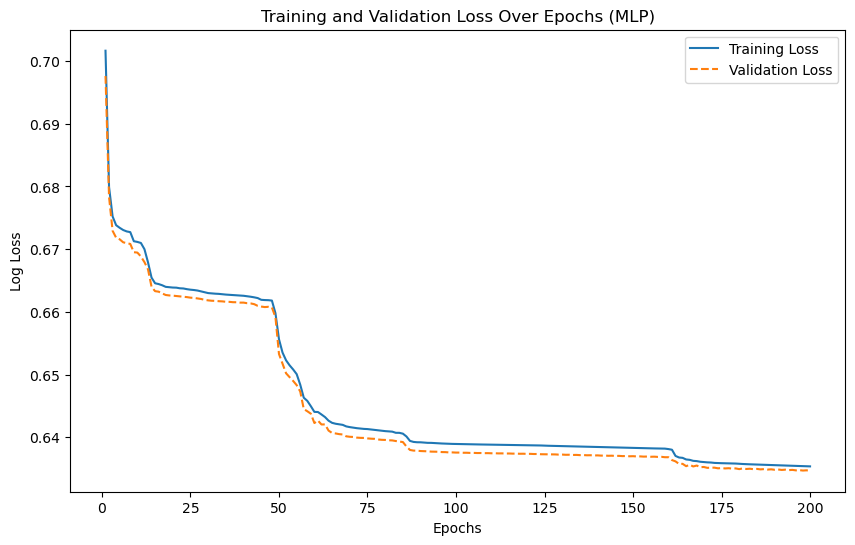

In [60]:
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

# Split training set further into training and validation subsets
X_train_full, X_train_split, Y_train_full, Y_train_split = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)

# Modify MLP definition to include early stopping for better learning process visualization
mlp = MLPClassifier(
    activation='tanh',
    hidden_layer_sizes=(10, 5),
    max_iter=1,  # Set to 1 for manual iteration control
    warm_start=True,  # Allows model to continue training from where it stopped
    solver='lbfgs',
    random_state=1
)

# Track errors
training_loss = []
validation_loss = []

for epoch in range(200):  # Simulating 200 epochs
    mlp.fit(X_train_full, Y_train_full)  # Train on training split
    
    # Track training loss
    Y_train_pred_proba = mlp.predict_proba(X_train_full)
    train_loss = log_loss(Y_train_full, Y_train_pred_proba)
    training_loss.append(train_loss)
    
    # Track validation loss
    Y_val_pred_proba = mlp.predict_proba(X_train_split)
    val_loss = log_loss(Y_train_split, Y_val_pred_proba)
    validation_loss.append(val_loss)
    
    # Print progress
    print(f"Epoch {epoch + 1}/{200}: Training Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")

# Plot Training vs Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, 201), training_loss, label="Training Loss")
plt.plot(range(1, 201), validation_loss, label="Validation Loss", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.title("Training and Validation Loss Over Epochs (MLP)")
plt.legend()
plt.show()


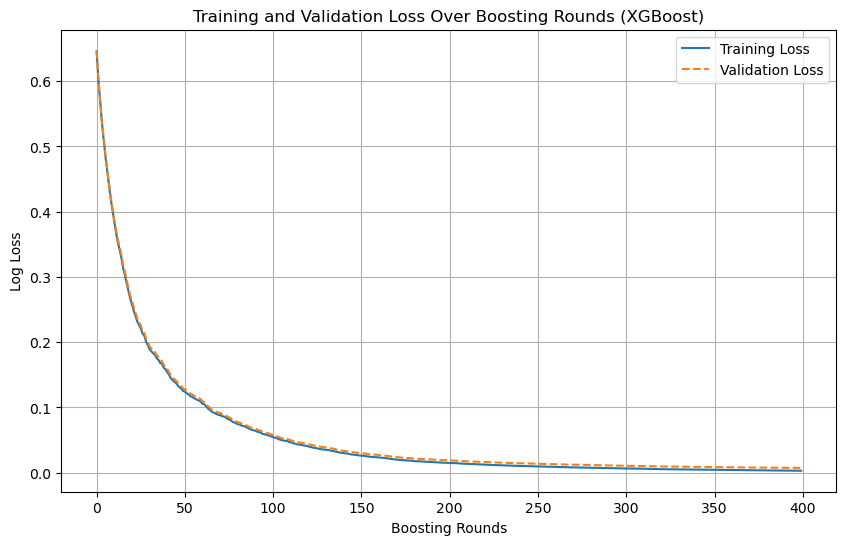

In [58]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Define the XGBoost model with eval_metric set in the constructor
xgb_model = XGBClassifier(
    random_state=0,
    n_estimators=400,  # Number of boosting rounds
    learning_rate=0.1,  # Step size for optimization
    eval_metric="logloss"  # Specify evaluation metric
)

# Train with validation set to track error reduction
xgb_model.fit(
    X_train, Y_train,
    eval_set=[(X_train, Y_train), (X_test, Y_test)],  # Specify train and validation datasets
    verbose=False  # Suppress detailed output
)

# Access evaluation results
evals_result = xgb_model.evals_result()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(evals_result['validation_0']['logloss'], label='Training Loss')
plt.plot(evals_result['validation_1']['logloss'], label='Validation Loss', linestyle='--')
plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss Over Boosting Rounds (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()


In [95]:
import pandas as pd
import numpy as np
import pickle

# Pick 100 random cases from the test set
num_cases = 10000
cases_index = np.random.choice(X_test.shape[0], num_cases, replace=False)
selected_cases = X_test[cases_index]
selected_labels = Y_test[cases_index]

# Load saved models
with open("mlp_model.sav", "rb") as file:
    mlp_model = pickle.load(file)
with open("logistic_regression_model.sav", "rb") as file:
    logistic_model = pickle.load(file)
with open("decision_tree_model.sav", "rb") as file:
    decision_tree_model = pickle.load(file)
with open("xgboost_model.sav", "rb") as file:
    xgb_model = pickle.load(file)

# Predict on the selected cases
mlp_predictions = mlp_model.predict(selected_cases)
logistic_predictions = logistic_model.predict(selected_cases)
decision_tree_predictions = decision_tree_model.predict(selected_cases)
xgb_predictions = xgb_model.predict(selected_cases)

# Combine predictions into a DataFrame
comparison_df = pd.DataFrame({
    "Case Index": cases_index,
    "True Label": selected_labels,
    "MLP Prediction": mlp_predictions,
    "Logistic Regression Prediction": logistic_predictions,
    "Decision Tree Prediction": decision_tree_predictions,
    "XGBoost Prediction": xgb_predictions
})

# Add columns to indicate prediction correctness
comparison_df["MLP Correct"] = comparison_df["MLP Prediction"] == comparison_df["True Label"]
comparison_df["Logistic Regression Correct"] = comparison_df["Logistic Regression Prediction"] == comparison_df["True Label"]
comparison_df["Decision Tree Correct"] = comparison_df["Decision Tree Prediction"] == comparison_df["True Label"]
comparison_df["XGBoost Correct"] = comparison_df["XGBoost Prediction"] == comparison_df["True Label"]

# Calculate metrics for each model
summary = {
    "Model": ["MLP", "Logistic Regression", "Decision Tree", "XGBoost"],
    "Correct Predictions": [
        comparison_df["MLP Correct"].sum(),
        comparison_df["Logistic Regression Correct"].sum(),
        comparison_df["Decision Tree Correct"].sum(),
        comparison_df["XGBoost Correct"].sum()
    ],
    "Accuracy (%)": [
        comparison_df["MLP Correct"].mean() * 100,
        comparison_df["Logistic Regression Correct"].mean() * 100,
        comparison_df["Decision Tree Correct"].mean() * 100,
        comparison_df["XGBoost Correct"].mean() * 100
    ],
    "False Negatives": [
        ((comparison_df["MLP Prediction"] == 0) & (comparison_df["True Label"] == 1)).sum(),
        ((comparison_df["Logistic Regression Prediction"] == 0) & (comparison_df["True Label"] == 1)).sum(),
        ((comparison_df["Decision Tree Prediction"] == 0) & (comparison_df["True Label"] == 1)).sum(),
        ((comparison_df["XGBoost Prediction"] == 0) & (comparison_df["True Label"] == 1)).sum()
    ],
    "False Positives": [
        ((comparison_df["MLP Prediction"] == 1) & (comparison_df["True Label"] == 0)).sum(),
        ((comparison_df["Logistic Regression Prediction"] == 1) & (comparison_df["True Label"] == 0)).sum(),
        ((comparison_df["Decision Tree Prediction"] == 1) & (comparison_df["True Label"] == 0)).sum(),
        ((comparison_df["XGBoost Prediction"] == 1) & (comparison_df["True Label"] == 0)).sum()
    ]
}

summary_df = pd.DataFrame(summary)

# Print summarized results
print("Summarized Results:")
print(summary_df)

# Select 5 random cases for detailed comparison
detailed_cases = comparison_df.sample(5, random_state=42)

# Print detailed results
print("\nDetailed Results for 5 Random Cases:")
print(detailed_cases)


C:\Users\pched\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.0.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\pched\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.0.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Summarized Results:
                 Model  Correct Predictions  Accuracy (%)  False Negatives  \
0                  MLP                 9786         97.86              106   
1  Logistic Regression                 7808         78.08             1126   
2        Decision Tree                 9464         94.64              109   
3              XGBoost                 9984         99.84                0   

   False Positives  
0              108  
1             1066  
2              427  
3               16  

Detailed Results for 5 Random Cases:
      Case Index  True Label  MLP Prediction  Logistic Regression Prediction  \
6252        8539           1               1                               1   
4684        6274           0               0                               0   
1731       13510           0               0                               0   
4742        6267           0               0                               0   
4521        3338           1               1  